In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import hddm
import kabuki
import arviz as az

print("The current version of kabuki is: ", kabuki.__version__)
print("The current version of HDDM is: ", hddm.__version__)
print("The current version of arviz is: ", az.__version__)

The current version of kabuki is:  0.6.5RC3
The current version of HDDM is:  0.9.8RC
The current version of arviz is:  0.15.1


# Load data

In [3]:
data = hddm.load_csv('/opt/conda/lib/python3.8/site-packages/hddm/examples/cavanagh_theta_nn.csv')

In [4]:
data.head(10)

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.210,1.0,0.656275,1,HC
1,0,WL,1.630,1.0,-0.327889,1,LC
2,0,WW,1.030,1.0,-0.480285,1,HC
3,0,WL,2.770,1.0,1.927427,1,LC
4,0,WW,1.140,0.0,-0.213236,1,HC
5,0,WL,1.150,1.0,-0.436204,1,LC
6,0,LL,2.000,1.0,-0.274479,1,HC
7,0,WL,1.040,0.0,0.666957,1,LC
8,0,WW,0.857,1.0,0.118617,1,HC
9,0,WL,1.500,0.0,0.823626,1,LC


In [5]:
import numpy as np
np.unique(data.subj_idx)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

`subj_idx`: Subject ID, 14 subjects with index starting from 0  
`stim`: Condition based on pairs of stimuli. Win-win (WW), lose-lose (LL), win-lose (WL)  
`rt`: Response time in seconds  
`reponse`: Accuracy coded (1 = correct, more rewarding stimulus selected).  
`theta`: Theta band EEG activity.  
`dbs`: Deep brain simulation on/off.  
`conf`: Conflict condition. WL is easiest and low conflict (LC); the other two conditions are high conflict (HC).  

Response times for all subjects

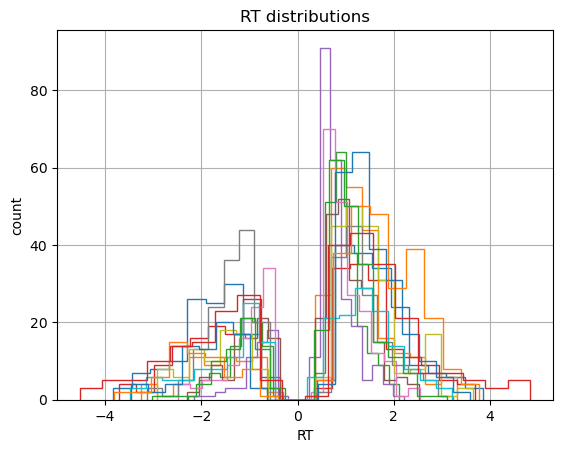

In [6]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# Fit a hierarchical model

In [7]:
%%time
# Instantiate model object passing it our data (no need to call flip_errors() before passing it).

# This will tailor an individual hierarchical DDM around your dataset.
m = hddm.HDDM(data, include = ['v', 'a', 't', 'z'],
                        informative = True,
                        is_group_model = True)
# find a good starting point which helps with the convergence.
m.find_starting_values()
# start drawing 2000 samples and discarding 20 as burn-in (usually you want to have a longer burn-in period)
m.sample(2000, burn=20)

No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 116.7 sechddm sampling elpased time:  116.805 s
CPU times: user 1min 57s, sys: 1.44 s, total: 1min 59s
Wall time: 1min 57s


In [8]:
stats = m.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.0', 'a_subj.1'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.975169,0.091756,1.811615,1.915929,1.970328,2.031021,2.177709,0.002215
a_std,0.340188,0.080591,0.222876,0.286658,0.327147,0.379024,0.538331,0.002857
a_subj.0,2.199783,0.065048,2.0675,2.157522,2.199529,2.244733,2.322979,0.002158
a_subj.1,2.114401,0.064579,1.990519,2.071232,2.113159,2.158239,2.240168,0.002377


Plotting a
Plotting a_std
Plotting v
Plotting t


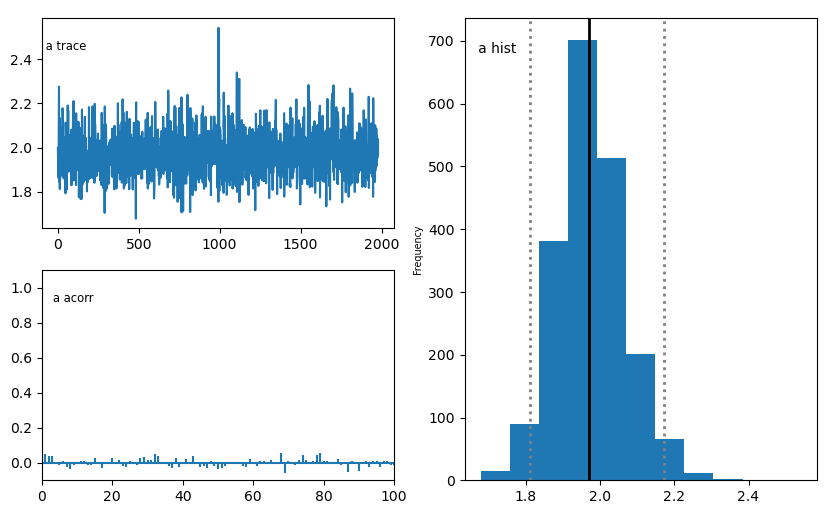

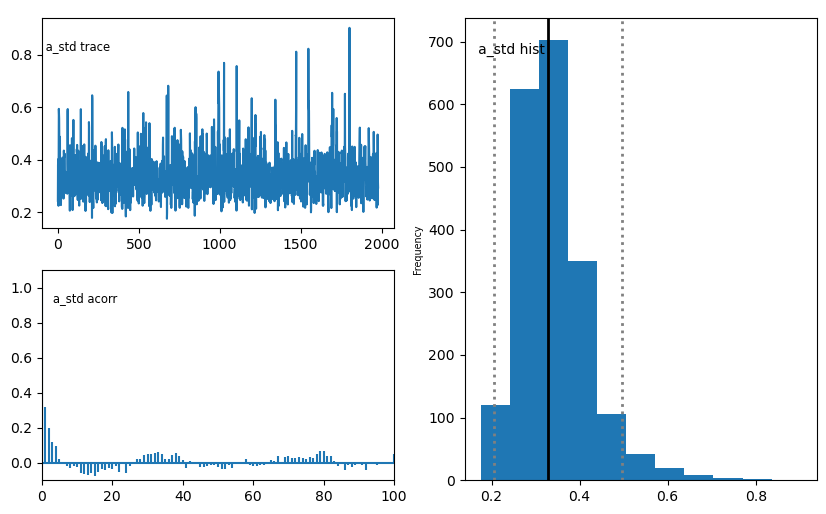

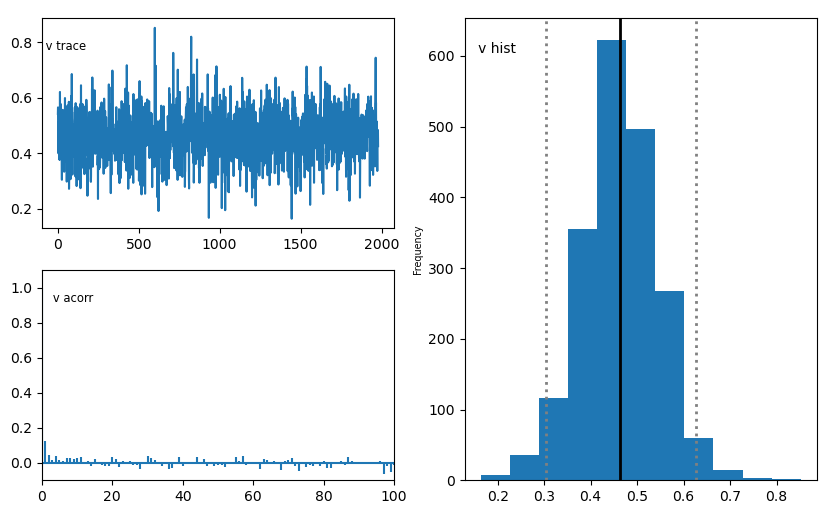

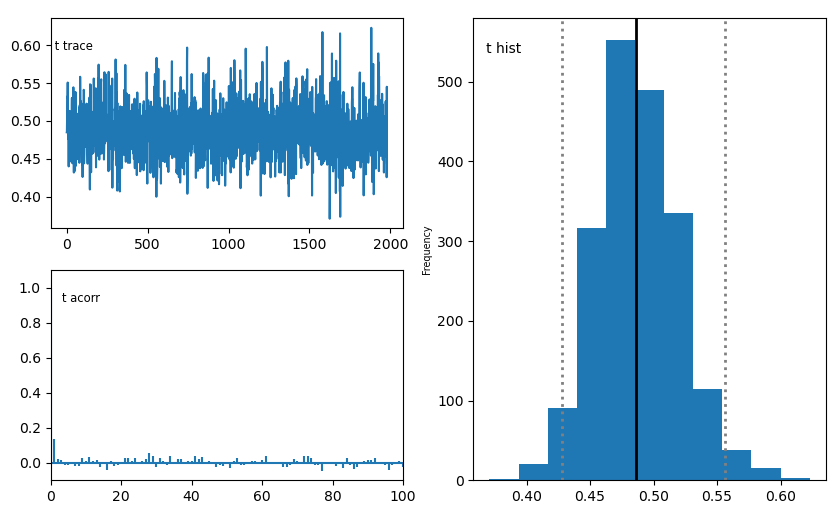

In [9]:
m.plot_posteriors(['a', 't', 'v', 'a_std'])

In [10]:
%%time
models = []
for i in range(5):
    m = hddm.HDDM(data, include = ['v', 'a', 't', 'z'],
                        informative = True,
                        is_group_model = True)
    m.find_starting_values()
    m.sample(2000, burn=500)
    models.append(m)

rhats = hddm.analyze.gelman_rubin(models)
rhats = pd.DataFrame.from_dict(rhats, orient='index', columns=['R_hat']).sort_values('R_hat', ascending=False)
rhats.head(20)

# The below code use the new argument `chains` and it is more faster than the origin code above. 
# import arviz as az
# models = hddm.HDDM(
#     data, 
#     include = ['v', 'a', 't', 'z'],
#     informative = True,
#     is_group_model = True
# )
# models.find_starting_values()
# infData = models.sample(2000, chains = 500, InfData = True)
# az.summary(infData, kind = 'diagnostics')

No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 115.4 sechddm sampling elpased time:  115.453 s
No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 92.1 sechddm sampling elpased time:  92.164 s
No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 92.9 sechddm sampling elpased time:  92.918 s
No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 93.7 sechddm sampling elpased time:  93.741 s
No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 92.8 sechddm sampling elpased time:  92.858 s
CPU times: user 8min 12s, sys: 2.73 s, total: 8min 15s
Wall time: 8min 12s


,R_hat
z_std,1.013736
z_subj_trans.6,1.007534
z_subj_trans.10,1.006029
z_subj_trans.5,1.005642
z_trans,1.005318
z_subj_trans.3,1.003722
z_subj_trans.13,1.003310
z_subj_trans.12,1.002942
z_subj_trans.8,1.002564
z_subj_trans.11,1.002503


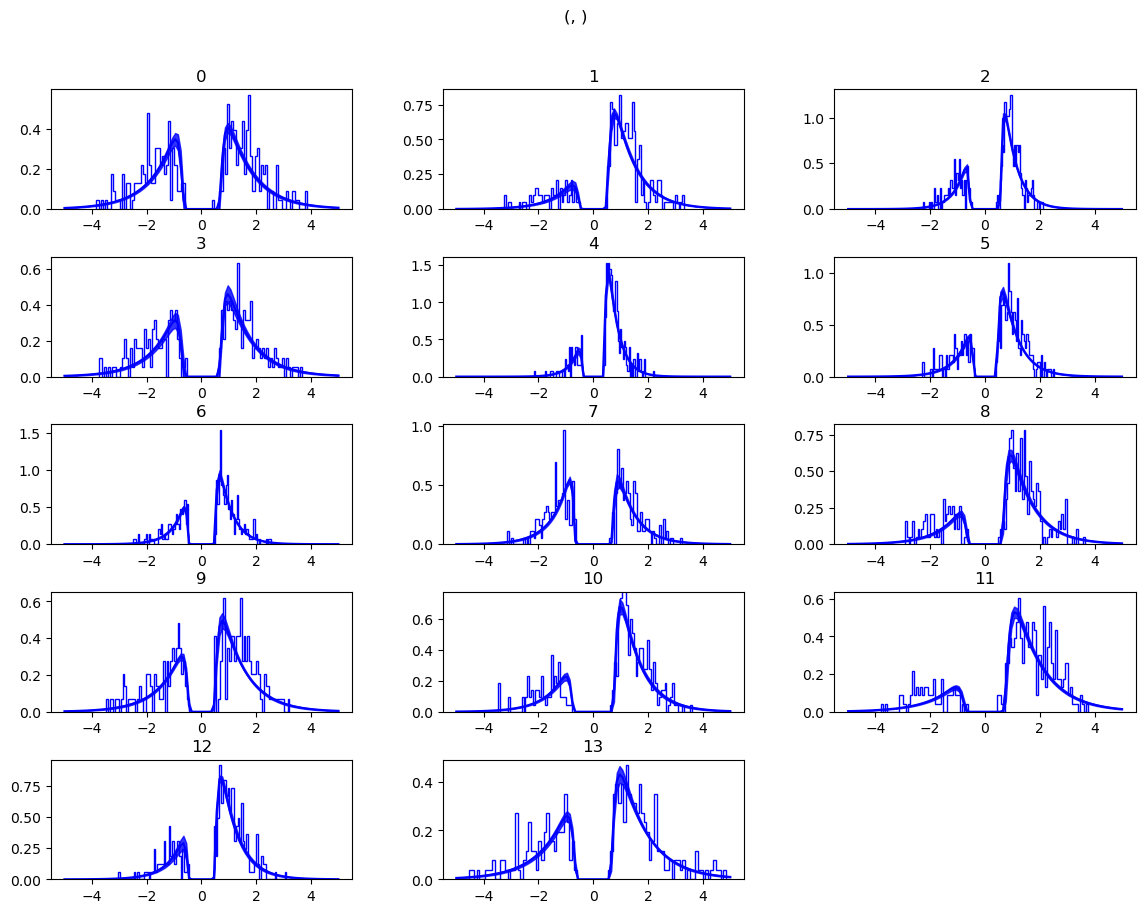

In [11]:
m.plot_posterior_predictive(figsize=(14, 10))

## Condition specific drift rates

In [12]:
%%time
m_stim = hddm.HDDM(data, include = ['v', 'a', 't', 'z'],
                   informative = True,
                   is_group_model = True,
                   depends_on={'v': 'stim'})
m_stim.find_starting_values()
m_stim.sample(2000, burn=100)

No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 191.4 sechddm sampling elpased time:  191.514 s
CPU times: user 3min 13s, sys: 1.01 s, total: 3min 14s
Wall time: 3min 13s


Text(0.5, 1.0, 'Posterior of drift-rate group means')

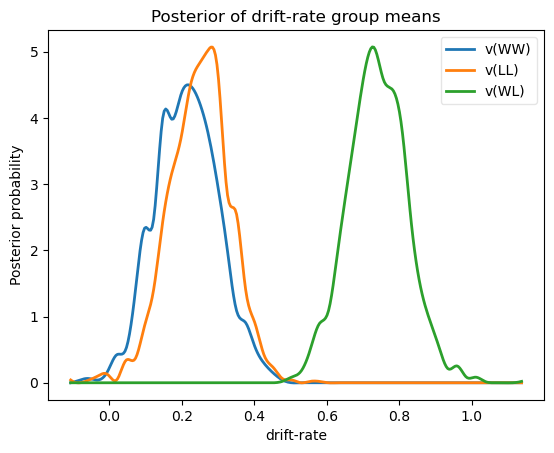

In [13]:
v_WW, v_LL, v_WL = m_stim.nodes_db.node[['v(WW)', 'v(LL)', 'v(WL)']]
hddm.analyze.plot_posterior_nodes([v_WW, v_LL, v_WL])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')

In [14]:
print("P(WW > LL) = ", (v_WW.trace() > v_LL.trace()).mean())
print("P(LL > WL) = ", (v_LL.trace() > v_WL.trace()).mean())

P(WW > LL) =  0.39263157894736844
P(LL > WL) =  0.0


In [15]:
print("Lumped model DIC: %f" % m.dic)
print("Stimulus model DIC: %f" % m_stim.dic)

Lumped model DIC: 10970.299289
Stimulus model DIC: 10781.395816


## Within-subject effects

In [16]:
from patsy import dmatrix
dmatrix("C(stim, Treatment('WL'))", data.head(10))

DesignMatrix with shape (10, 3)
  Intercept  C(stim, Treatment('WL'))[T.LL]  C(stim, Treatment('WL'))[T.WW]
          1                               1                               0
          1                               0                               0
          1                               0                               1
          1                               0                               0
          1                               0                               1
          1                               0                               0
          1                               1                               0
          1                               0                               0
          1                               0                               1
          1                               0                               0
  Terms:
    'Intercept' (column 0)
    "C(stim, Treatment('WL'))" (columns 1:3)

In [17]:
m_within_subj = hddm.HDDMRegressor(data, "v ~ C(stim, Treatment('WL'))", 
                                   include = ['v', 'a', 't', 'z'],
                                   informative = True,
                                   is_group_model = True)

No model attribute --> setting up standard HDDM
Set model to ddm


In [18]:
%%time
m_within_subj.sample(2000, burn=100)

 [-----------------100%-----------------] 2001 of 2000 complete in 744.4 sechddm sampling elpased time:  744.549 s
CPU times: user 12min 1s, sys: 3.06 s, total: 12min 4s
Wall time: 12min 24s


Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

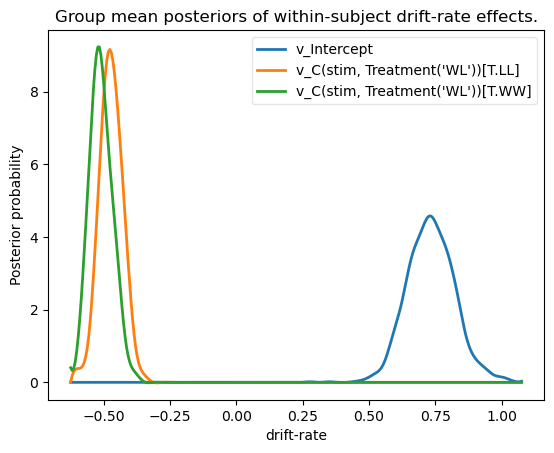

In [19]:
v_WL, v_LL, v_WW = m_within_subj.nodes_db.loc[["v_Intercept",
                                              "v_C(stim, Treatment('WL'))[T.LL]",
                                              "v_C(stim, Treatment('WL'))[T.WW]"], 'node']
hddm.analyze.plot_posterior_nodes([v_WL, v_LL, v_WW])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')

## Fitting regression models

In [20]:
m_reg = hddm.HDDMRegressor(data[data.dbs == 0],
                           "a ~ theta:C(conf, Treatment('LC'))",
                           depends_on={'v': 'stim'},
                           include = ['v', 'a', 't', 'z'],
                           informative = True,
                           is_group_model = True)

No model attribute --> setting up standard HDDM
Set model to ddm


In [21]:
%%time
m_reg.sample(2000, burn=100)

 [-----------------100%-----------------] 2001 of 2000 complete in 1159.0 sechddm sampling elpased time:  1159.11 s
CPU times: user 19min 18s, sys: 16.3 s, total: 19min 34s
Wall time: 19min 19s


In [22]:
m_reg_stats = m_reg.gen_stats()
# pd.set_option('display.max_rows', None)
m_reg_stats.head(20)

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
v(LL),0.258517,0.105892,0.059449,0.187059,0.255109,0.329166,0.480798,0.003271
v(WL),0.796696,0.102418,0.596974,0.727481,0.796586,0.862167,1.007955,0.003112
v(WW),0.246334,0.109022,0.032249,0.17341,0.242486,0.31937,0.462294,0.003774
v_std,0.340569,0.057099,0.243742,0.300475,0.336372,0.376831,0.465112,0.002146
v_subj(LL).0,-0.030897,0.144402,-0.317467,-0.128066,-0.029294,0.060989,0.262299,0.004238
v_subj(LL).1,0.186612,0.154358,-0.11334,0.083179,0.187314,0.287427,0.489883,0.004823
v_subj(LL).2,0.248279,0.171083,-0.098126,0.132906,0.243348,0.371966,0.578745,0.004228
v_subj(LL).3,-0.145319,0.151807,-0.445461,-0.244728,-0.143974,-0.044172,0.142131,0.004022
v_subj(LL).4,0.628622,0.221486,0.214315,0.482594,0.624831,0.773579,1.074003,0.006453
v_subj(LL).5,0.402985,0.164832,0.089829,0.288264,0.397344,0.512491,0.733263,0.004676


P(a_theta < 0) =  0.05105263157894737


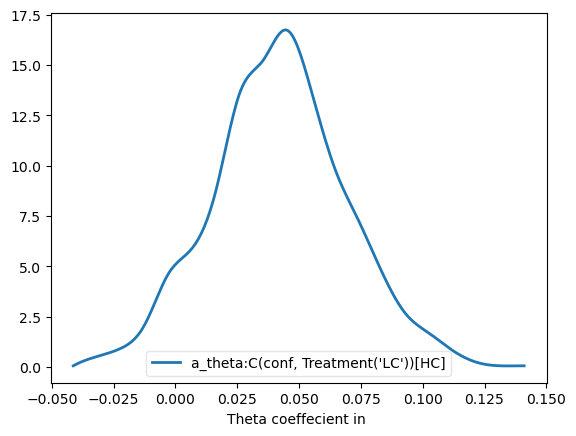

In [23]:
theta = m_reg.nodes_db.node["a_theta:C(conf, Treatment('LC'))[HC]"]
hddm.analyze.plot_posterior_nodes([theta], bins=20)
plt.xlabel('Theta coeffecient in ')
print("P(a_theta < 0) = ", (theta.trace() < 0).mean())

## Dealing with outliers

In [24]:
outlier_data, params = hddm.generate.gen_rand_data(params={'a': 2, 't': .4, 'v': .5},
                                                   size=200, n_fast_outliers=10)

/opt/conda/lib/python3.8/site-packages/hddm/generate.py:1393: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers.loc[:, "rt"].iloc[:n_fast] = (
/opt/conda/lib/python3.8/site-packages/hddm/generate.py:1398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers.loc[:, "rt"].iloc[n_fast:] = np.random.rand(n_slow) * 2 + max(


In [25]:
%%time
m_no_outlier = hddm.HDDM(outlier_data, p_outlier = 0.0,
                         include = ['v', 'a', 't', 'z'],
                         informative = True,
                         is_group_model = False)
m_no_outlier.sample(2000, burn=50)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 2000 of 2000 complete in 8.3 sechddm sampling elpased time:  8.291 s
CPU times: user 8.21 s, sys: 233 ms, total: 8.45 s
Wall time: 8.32 s


/opt/conda/lib/python3.8/site-packages/kabuki/analyze.py:543: UserWarning: Too many nodes. Consider increasing number of columns.
  warnings.warn("Too many nodes. Consider increasing number of columns.")


Text(0, 0.5, 'Probability density')

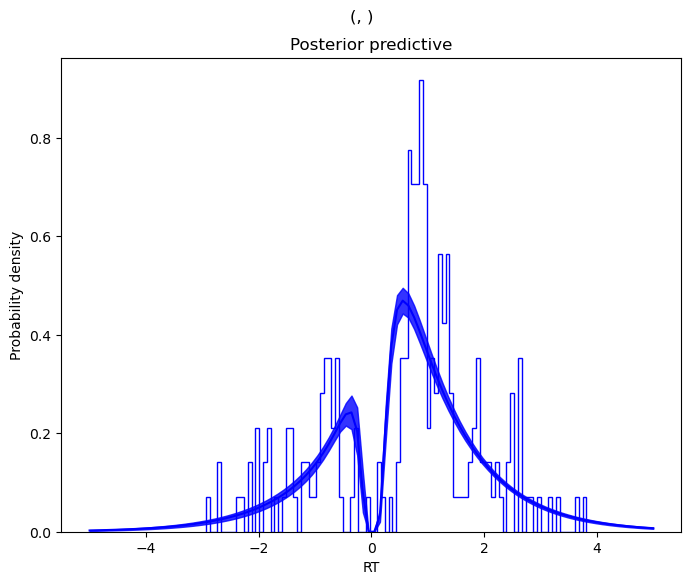

In [26]:
m_no_outlier.plot_posterior_predictive()
plt.title('Posterior predictive')
plt.xlabel('RT')
plt.ylabel('Probability density')

In [27]:
%%time
m_outlier = hddm.HDDM(outlier_data, p_outlier=.05,
                      include = ['v', 'a', 't', 'z'],
                      informative = True,
                      is_group_model = False)
m_outlier.sample(2000, burn=50)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 2000 of 2000 complete in 9.6 sechddm sampling elpased time:  9.634 s
CPU times: user 9.7 s, sys: 249 ms, total: 9.95 s
Wall time: 9.67 s


/opt/conda/lib/python3.8/site-packages/kabuki/analyze.py:543: UserWarning: Too many nodes. Consider increasing number of columns.
  warnings.warn("Too many nodes. Consider increasing number of columns.")


Text(0, 0.5, 'Probability density')

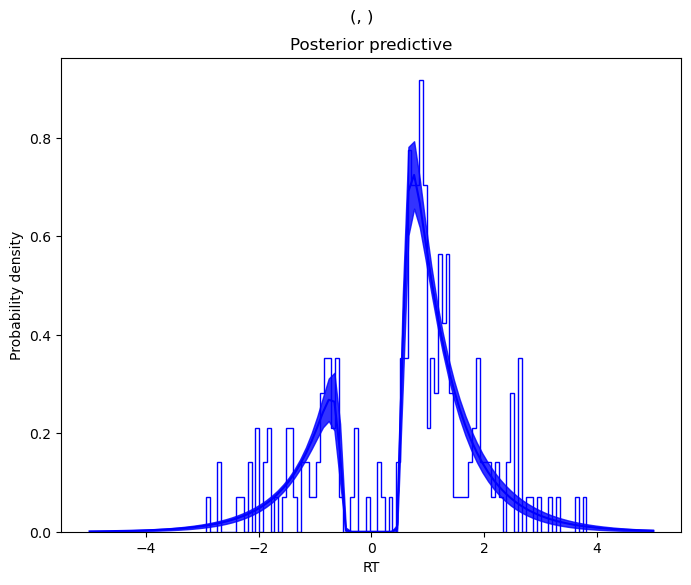

In [28]:
m_outlier.plot_posterior_predictive()
plt.title('Posterior predictive')
plt.xlabel('RT')
plt.ylabel('Probability density')